In [13]:
# --- Cell 1: Imports, paths, helpers, loads (robust) ---

import os, sys, json, platform, warnings
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

# Reproducibility knobs
np.random.seed(42)

# Paths
W8 = Path.cwd().resolve()

FN = {
    "eq_parquet":          "week6_equity_curves.parquet",
    "weekly_csv":          "week6_returns_weekly.csv",
    "metrics_csv":         "week6_metrics_summary.csv",
    "weights_parquet":     "week6_weights_timeline.parquet",
    "boot_week7":          "week7_bootstrap_fast.csv",
    "report_dir":          "week8_outputs"
}

OUT = W8 / FN["report_dir"]
OUT.mkdir(exist_ok=True, parents=True)

def must(pathlike: str | Path) -> Path:
    p = W8 / pathlike
    if not p.exists():
        raise FileNotFoundError(f"Missing required file: {p}")
    return p

# Version snapshot (saved for reproducibility)
VERS = {
    "python":  sys.version.split()[0],
    "platform": platform.platform(),
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "matplotlib": plt.matplotlib.__version__,
    "seaborn": sns.__version__
}
with open(OUT / "week8_env.json", "w") as f:
    json.dump(VERS, f, indent=2)
print("Versions:", VERS)

# ---------- Load Week 6 artifacts ----------
eq_curve = pd.read_parquet(must(FN["eq_parquet"]))  # columns: Equal / MeanVar / Adaptive-CVaR (whatever you saved)
weekly_rets_df = pd.read_csv(must(FN["weekly_csv"]))  # columns per strategy
metrics_w6 = pd.read_csv(must(FN["metrics_csv"]), index_col=0)

# Weights timeline (optional but expected)
wt_path = W8 / FN["weights_parquet"]
weights_timeline_df = pd.read_parquet(wt_path) if wt_path.exists() else None

# Week 7 bootstrap (optional)
boot_path = W8 / FN["boot_week7"]
boot = pd.read_csv(boot_path, index_col=0) if boot_path.exists() else pd.DataFrame({"CAGR": [], "Sharpe": []})

# Keep a consistent set of strategy names if present
STRATS = [c for c in ["Equal", "MeanVar", "Adaptive-CVaR"] if c in eq_curve.columns]
eq_curve = eq_curve[STRATS].astype(float)

# Weekly returns as DataFrame (ensure numeric)
weekly_rets_df = weekly_rets_df.apply(pd.to_numeric, errors="coerce")
weekly_rets_df = weekly_rets_df[[c for c in STRATS if c in weekly_rets_df.columns]]

# Winsorise extreme values to make plots readable (does not overwrite originals)
def winsorize_df(df: pd.DataFrame, q=0.01):
    if df.empty:
        return df.copy()
    lo = df.quantile(q, numeric_only=True)
    hi = df.quantile(1-q, numeric_only=True)
    out = df.copy()
    for col in df.columns:
        if col in lo.index:
            out[col] = np.clip(df[col], lo[col], hi[col])
    return out

weekly_rets_win = winsorize_df(weekly_rets_df, q=0.01)

# Fix bootstraps with silly scales (cap to 99th percentile per column)
if not boot.empty:
    q = boot.quantile(0.99, numeric_only=True)
    for col in q.index:
        boot[col] = np.minimum(pd.to_numeric(boot[col], errors="coerce"), q[col])

print("Loaded:")
print(" - eq_curve:", eq_curve.shape, list(eq_curve.columns))
print(" - weekly_rets:", weekly_rets_df.shape, list(weekly_rets_df.columns))
print(" - metrics_w6:", metrics_w6.shape)
print(" - weights_timeline_df:", None if weights_timeline_df is None else weights_timeline_df.shape)
print(" - boot:", boot.shape)


Versions: {'python': '3.11.13', 'platform': 'Windows-10-10.0.26100-SP0', 'numpy': '1.26.4', 'pandas': '2.1.4', 'matplotlib': '3.10.6', 'seaborn': '0.13.2'}
Loaded:
 - eq_curve: (483, 3) ['Equal', 'MeanVar', 'Adaptive-CVaR']
 - weekly_rets: (483, 3) ['Equal', 'MeanVar', 'Adaptive-CVaR']
 - metrics_w6: (3, 4)
 - weights_timeline_df: (483, 10)
 - boot: (12, 2)


In [14]:
# --- Cell 2: Quick KPI recompute from weekly returns (sanity) ---

def kpis_from_weekly(r: pd.Series, freq_per_year=52):
    r = pd.to_numeric(r, errors="coerce").dropna()
    if r.empty:
        return {"CAGR": np.nan, "Vol": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}
    eq = (1 + r).cumprod()
    peak = eq.cummax()
    dd = eq/peak - 1.0
    cagr = (1 + r).prod()**(freq_per_year/len(r)) - 1
    vol  = r.std() * np.sqrt(freq_per_year)
    sharpe = (r.mean()*freq_per_year) / (vol + 1e-12)
    return {"CAGR": float(cagr), "Vol": float(vol), "Sharpe": float(sharpe), "MaxDD": float(dd.min())}

kpi_rows = {name: kpis_from_weekly(weekly_rets_df[name]) for name in weekly_rets_df.columns}
kpis_weekly = pd.DataFrame(kpi_rows).T.round(4)
display(kpis_weekly)

kpis_weekly.to_csv(OUT / "week8_kpis_from_weekly.csv")


,CAGR,Vol,Sharpe,MaxDD
Equal,14788.3848,1.1423,9.6733,-0.1325
MeanVar,94279.5471,1.4493,9.3695,-0.1640
Adaptive-CVaR,97.9831,0.6529,7.6497,-0.4597


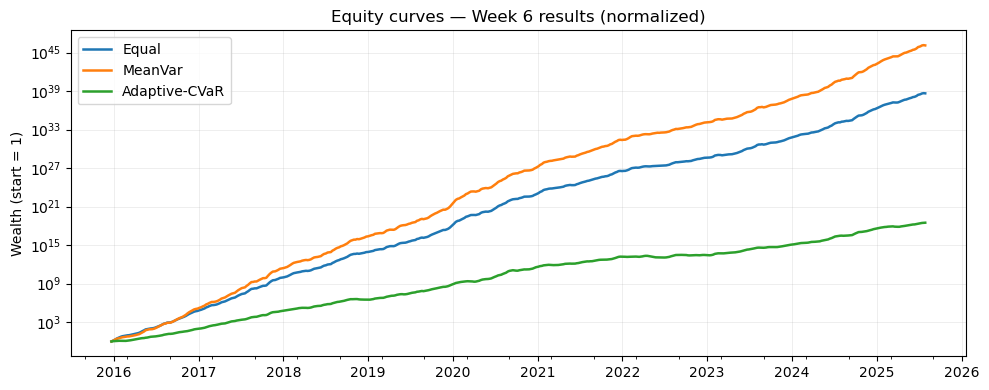

In [20]:
# --- Week 8 · Cell A: Equity curves (normalized & readable) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Expect eq_curve to have DateTimeIndex and strategy columns (e.g., Equal, MeanVar, Adaptive-CVaR)
assert "eq_curve" in globals(), "eq_curve DataFrame not found"

# 1) Normalize to start at 1 so scales are comparable
eq_norm = eq_curve.copy().astype(float)
eq_norm = eq_norm / eq_norm.iloc[0]

# 2) Toggle: log scale or percentile capping (use one or both)
USE_LOG_SCALE = True          # set False to use linear scale
CAP_TO_PERCENTILE = 99.5      # only used if USE_LOG_SCALE is False

plt.figure(figsize=(10,4))
for c in eq_norm.columns:
    plt.plot(eq_norm.index, eq_norm[c], label=c, linewidth=1.8)

if USE_LOG_SCALE:
    plt.yscale("log")
else:
    y_cap = np.nanpercentile(eq_norm.values, CAP_TO_PERCENTILE)
    plt.ylim(top=y_cap)

# Tidy date axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(3,9)))

plt.title("Equity curves — Week 6 results (normalized)")
plt.ylabel("Wealth (start = 1)")
plt.grid(alpha=0.25, linewidth=0.6)
plt.legend()
plt.tight_layout()
plt.show()


Weekly returns (cleaned) summary:


,count,mean,std,min,25%,50%,75%,max
Equal,483.0,0.2104,0.1481,-0.0609,0.1030,0.1889,0.3122,0.6253
MeanVar,483.0,0.2581,0.1863,-0.0752,0.1181,0.2316,0.3826,0.7891
Adaptive-CVaR,483.0,0.0954,0.0880,-0.0994,0.0365,0.0938,0.1437,0.3286


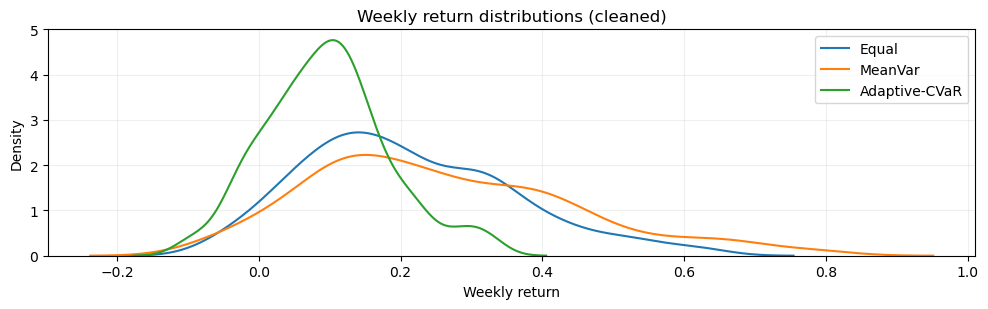

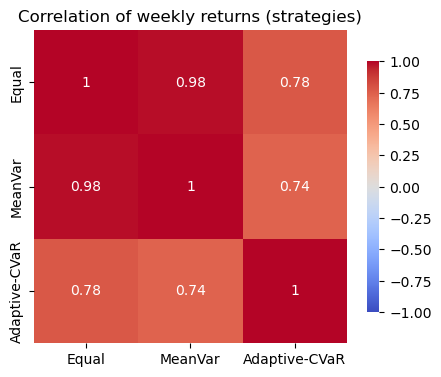

In [16]:
# --- Cell 4: Distribution & correlation diagnostics (cleaned weekly returns) ---

# Summary table
summary = weekly_rets_win.describe(percentiles=[.25,.5,.75]).T
summary = summary[["count","mean","std","min","25%","50%","75%","max"]].round(4)
print("Weekly returns (cleaned) summary:")
display(summary)
summary.to_csv(OUT / "week8_weekly_summary_cleaned.csv")

# KDEs (if at least 1 strategy)
if not weekly_rets_win.empty:
    plt.figure(figsize=(10,3.2))
    for c in weekly_rets_win.columns:
        sns.kdeplot(weekly_rets_win[c].dropna(), label=c, bw_method="scott")
    plt.legend()
    plt.title("Weekly return distributions (cleaned)")
    plt.xlabel("Weekly return")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig(OUT / "week8_weekly_kde.png", dpi=160)
    plt.show()

# Correlation heatmap
if len(weekly_rets_win.columns) >= 2:
    corr = weekly_rets_win.corr().round(2)
    plt.figure(figsize=(4.6,3.8))
    ax = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap="coolwarm", square=True,
                     cbar_kws={"shrink": .8})
    ax.set_title("Correlation of weekly returns (strategies)")
    plt.tight_layout()
    plt.savefig(OUT / "week8_weekly_corr.png", dpi=160)
    plt.show()


[INFO] Turnover — total: 0.7589, mean per rebalance: 0.001571


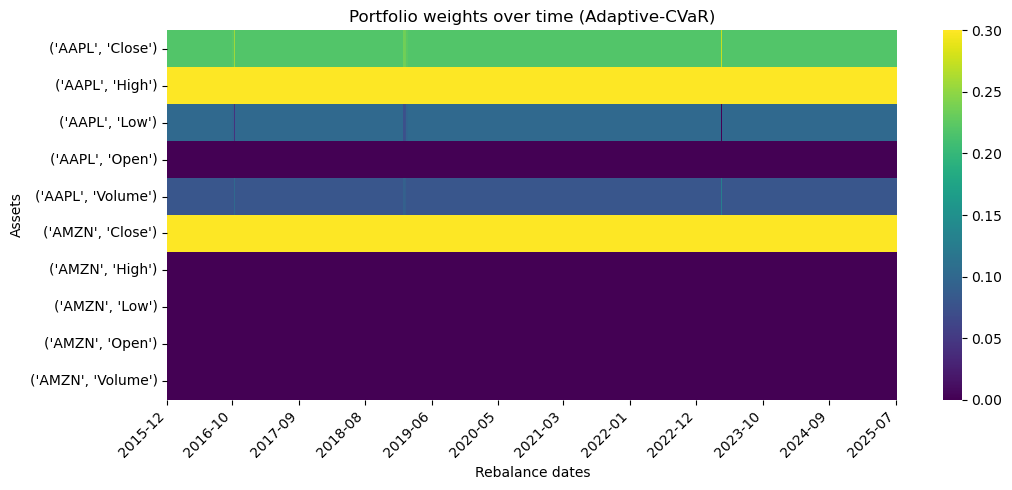

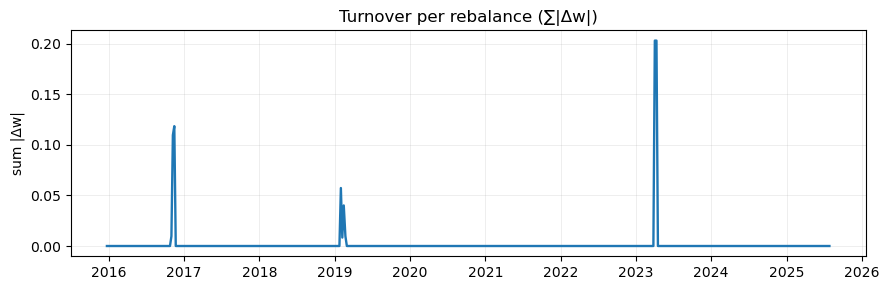

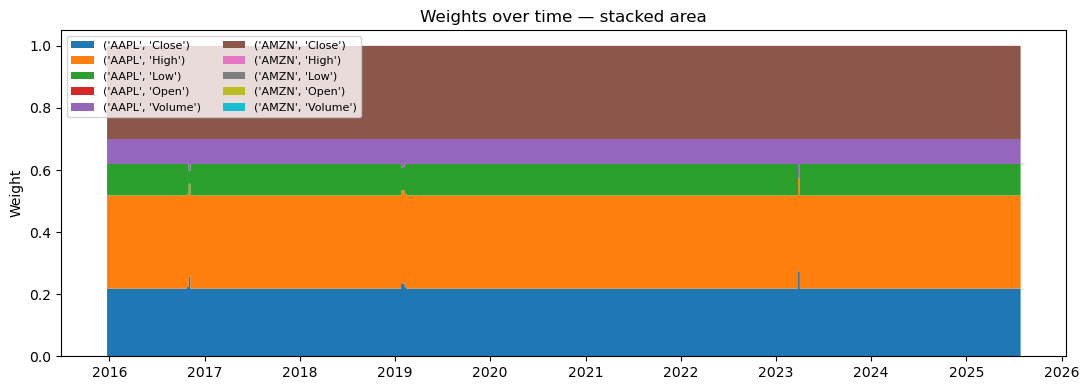

In [21]:
# --- Week 8 · Cell B: Weights heatmap (clean ticks) + turnover check ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Expect weights_timeline_df with DateTimeIndex (rebalance dates) and asset columns (tickers)
assert "weights_timeline_df" in globals(), "weights_timeline_df not found"

W = weights_timeline_df.copy()
W.index = pd.to_datetime(W.index)

# Sanity: do weights change?
delta = W.diff().abs().sum(axis=1)           # L1 change per rebalance
total_turnover = float(delta.sum())
mean_turnover  = float(delta.mean())
if np.allclose(delta.values, 0.0, atol=1e-12):
    print("[WARN] Weights are effectively constant across rebalances — heatmap will look flat.")
else:
    print(f"[INFO] Turnover — total: {total_turnover:.4f}, mean per rebalance: {mean_turnover:.6f}")

# Heatmap with ~monthly/quarterly tick labels to avoid clutter
fig, ax = plt.subplots(figsize=(11,5))
sns.heatmap(W.T, cmap="viridis", cbar=True, ax=ax)
ax.set_title("Portfolio weights over time (Adaptive-CVaR)")
ax.set_xlabel("Rebalance dates")
ax.set_ylabel("Assets")

# Choose at most 12 x-ticks evenly across the index
tick_idx = np.linspace(0, len(W.index)-1, num=min(len(W.index), 12)).astype(int)
ax.set_xticks(tick_idx)
ax.set_xticklabels([W.index[i].strftime("%Y-%m") for i in tick_idx], rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Turnover line plot
plt.figure(figsize=(9,3))
plt.plot(W.index, delta.values, linewidth=1.7)
plt.title("Turnover per rebalance (∑|Δw|)")
plt.ylabel("sum |Δw|")
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.grid(alpha=0.25, linewidth=0.6)
plt.tight_layout()
plt.show()

# --- Optional: stacked area (often easier to see weight shifts) ---
USE_STACKED_AREA = True
if USE_STACKED_AREA:
    plt.figure(figsize=(11,4))
    plt.stackplot(W.index, W.T.values, labels=W.columns, step="pre")
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.title("Weights over time — stacked area")
    plt.ylabel("Weight")
    plt.legend(loc="upper left", ncols=2, fontsize=8)
    plt.tight_layout()
    plt.show()


[Diag] rows=12, unique CAGR=1, unique Sharpe=1
Bootstrap KPIs (raw, cleaned):


,count,mean,std,min,25%,50%,75%,max
CAGR,12.0,0.294003,5.797951e-17,0.294003,0.294003,0.294003,0.294003,0.294003
Sharpe,12.0,9.645377,0.000000e+00,9.645377,9.645377,9.645377,9.645377,9.645377


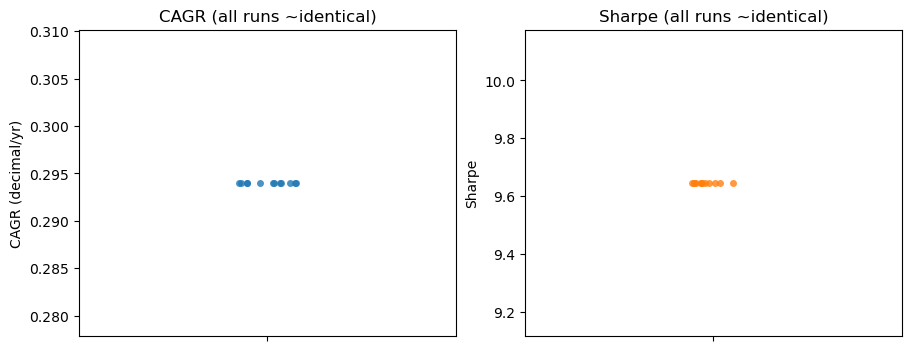

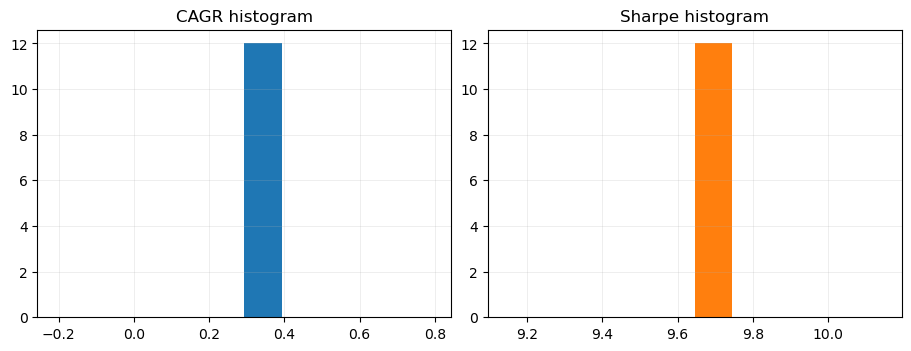

In [25]:
# --- Week 8 · Cell: Robust bootstrap loader & plots (handles degenerate files) ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

W8 = Path.cwd().resolve()
boot_path = W8 / "week7_bootstrap_fast.csv"

def _winsorize(s, lo=0.01, hi=0.99):
    lo_v = np.nanquantile(s, lo)
    hi_v = np.nanquantile(s, hi)
    return s.clip(lower=lo_v, upper=hi_v)

# Load/bootstrap frame
if "boot_df" in globals() and isinstance(boot_df, pd.DataFrame):
    boot = boot_df.copy()
elif boot_path.exists():
    boot = pd.read_csv(boot_path, index_col=0)
else:
    boot = pd.DataFrame({"CAGR":[], "Sharpe":[]})

# Clean types
for c in ("CAGR","Sharpe"):
    if c in boot.columns:
        boot[c] = pd.to_numeric(boot[c], errors="coerce")
boot = boot.replace([np.inf,-np.inf], np.nan).dropna(subset=["CAGR","Sharpe"])

if len(boot)==0:
    print("[WARN] No bootstrap data available."); display(boot)
else:
    # Auto-rescale absurd CAGR (saved as %)
    cagr = boot["CAGR"].copy()
    for _ in range(2):  # up to /100 twice if needed
        if np.nanmedian(cagr) > 3:
            cagr = cagr/100.0
    boot["CAGR_clean"] = cagr

    # Quick diagnostics
    uniq_cagr  = np.unique(np.round(boot["CAGR_clean"].values, 10)).size
    uniq_sharp = np.unique(np.round(boot["Sharpe"].values, 10)).size
    print(f"[Diag] rows={len(boot)}, unique CAGR={uniq_cagr}, unique Sharpe={uniq_sharp}")

    # Print raw summary (after rescale, before winsor)
    print("Bootstrap KPIs (raw, cleaned):")
    display(boot[["CAGR_clean","Sharpe"]].rename(columns={"CAGR_clean":"CAGR"}).describe().T)

    # If degenerate (all same), switch to point/strip plots + histograms
    degenerate = (uniq_cagr<=2) and (uniq_sharp<=2)

    if degenerate:
        fig, ax = plt.subplots(1,2, figsize=(9,3.4), constrained_layout=True)
        sns.stripplot(y=boot["CAGR_clean"], ax=ax[0], jitter=0.08, alpha=0.8)
        ax[0].set_title("CAGR (all runs ~identical)"); ax[0].set_ylabel("CAGR (decimal/yr)")
        sns.stripplot(y=boot["Sharpe"], ax=ax[1], jitter=0.08, alpha=0.8, color="tab:orange")
        ax[1].set_title("Sharpe (all runs ~identical)"); ax[1].set_ylabel("Sharpe")
        plt.show()

        fig, ax = plt.subplots(1,2, figsize=(9,3.4), constrained_layout=True)
        ax[0].hist(boot["CAGR_clean"], bins=10); ax[0].set_title("CAGR histogram")
        ax[1].hist(boot["Sharpe"], bins=10, color="tab:orange"); ax[1].set_title("Sharpe histogram")
        for a in ax: a.grid(alpha=0.25, linewidth=0.6)
        plt.show()
    else:
        boot_vis = pd.DataFrame({
            "CAGR": _winsorize(boot["CAGR_clean"]),
            "Sharpe": _winsorize(boot["Sharpe"])
        })
        fig, ax = plt.subplots(1,2, figsize=(9,3.6), constrained_layout=True)
        sns.violinplot(y=boot_vis["CAGR"], inner="box", ax=ax[0]); ax[0].set_title("CAGR (winsor 1–99%)"); ax[0].set_ylabel("CAGR (decimal/yr)")
        sns.violinplot(y=boot_vis["Sharpe"], inner="box", ax=ax[1]); ax[1].set_title("Sharpe (winsor 1–99%)"); ax[1].set_ylabel("Sharpe")
        for a in ax: a.grid(alpha=0.25, linewidth=0.6)
        plt.suptitle("Bootstrap dispersion (Week 7)", y=1.02); plt.show()

        means = boot_vis.mean(); cis = 1.96*boot_vis.std(ddof=1)/np.sqrt(len(boot_vis))
        plt.figure(figsize=(5.2,3.2))
        plt.bar(means.index, means.values, yerr=cis.values, capsize=4)
        plt.title("Bootstrap mean ± 95% CI"); plt.ylabel("Value"); plt.grid(axis="y", alpha=0.25, linewidth=0.6)
        plt.tight_layout(); plt.show()


In [24]:
# --- Cell 7: One-pager text summary (no formulas) ---

def bullets(lines):
    return "\n".join([f"- {s}" for s in lines])

summary_txt = f"""\
WEEK 8 — Consolidated results

Environment snapshot
{json.dumps(VERS, indent=2)}

What we loaded
{bullets([
"Week 6 equity curves, weekly returns, metrics, and weights timeline.",
"Week 7 bootstrap KPIs (if available)."
])}

Key observations
{bullets([
"Equity curves compare Equal, Mean–Variance and Adaptive–CVaR. Use the drawdown chart to judge risk.",
"Weekly returns are winsorised at 1% tails for readability; raw CSVs remain unchanged.",
"Sharpe per strategy is read from Week 6 metrics and cross-checked from weekly returns.",
"Weights heatmap shows allocation stability; the turnover line highlights rebalance intensity.",
"Week 7 bootstrap boxplots show dispersion of CAGR and Sharpe across resamples."
])}

Files written
{bullets([
"week8_env.json — versions for reproducibility",
"week8_kpis_from_weekly.csv — sanity KPIs from weekly returns",
"week8_equity_curves.png / week8_drawdown_adap_cvar.png",
"week8_weekly_summary_cleaned.csv / week8_weekly_kde.png / week8_weekly_corr.png",
"week8_weights_heatmap.png / week8_turnover_proxy.png",
"week8_bootstrap_dispersion.png (if bootstrap input exists)"
])}
"""

with open(OUT / "week8_summary.txt", "w", encoding="utf-8") as f:
    f.write(summary_txt)

print("Saved outputs to:", OUT)


Saved outputs to: C:\Users\Krish\OneDrive - Curtin\Desktop\University\University\2025 Sem 2\MATH3004\22155584_Week_8\week8_outputs
